# Notebook 7: Logistic Regression and SoftMax for MNIST

## Learning Goal

The goal of this notebook is to familiarize the reader with SoftMax regression (a generalization of logistic regression to more than two categories), categorical predictions, and the MNIST handwritten dataset. The reader will understand how to use the Scikit Logistic regression package and visualize learned weights.

## Overview
### The MNIST dataset:
The MNIST classification problem is one of the classical ML problems for learning classification on high-dimensional data with a fairly sizable number of examples (60000). Yann LeCun and collaborators collected and processed $70000$ handwritten digits (60000 are used for training and 10000 for testing) to produce what became known as one of the most widely used datasets in ML: the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Each handwritten digit comes in a grayscale square image in the shape of a $28\times 28$ pixel grid. Every pixel takes a value in the range $[0,255]$, representing $256$ nuances of the gray color. The problem of image classification finds applications in a wide range of fields and is important for numerous industry applications of ML. 
### SoftMax regression:
We will use SoftMax regression, which can be thought of as a statistical model which assigns a probability that a given input image corresponds to any of the 10 handwritten digits. The model is a generalization of the logistic regression and reads:
\begin{align}
p(y=i|\boldsymbol{x};W) = \frac{e^{\boldsymbol{w}_i^T \boldsymbol{x}}}{\sum_{j=0}^9 e^{\boldsymbol{w}_j^T}},
\end{align}
Where $p(y=i|\boldsymbol{x};W)$ is the probability that input $\boldsymbol{x}$ is the $i$-th digit, $i\in[0,9]$.
The model also has 10 weight vectors $\boldsymbol{w}_i$ which we will train below. Finally, one can use this information for prediction by taking the value of $y$ for which this probability is maximized:
\begin{align}
y_{pred}=\arg\max_i p(y=i|\boldsymbol{x})
\end{align}

## Numerical Experiments

The reader is invited to check out the code below to build up their intuition about SoftMax regression. The following notebook is a slight modification of [this Scikit tutorial](http://scikit-learn.org/dev/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html) by Arthur Mensch on studying the MNIST problem using Logistic Regression.

In [1]:
import time
import numpy as np

from sklearn.datasets import fetch_openml # MNIST data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

print(__doc__)

# Turn down for faster convergence
t0 = time.time()
train_size = 50000
test_size = 10000

### load MNIST data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# shuffle data
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

# pick training and test data sets 
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size,test_size=test_size)

# scale data to have zero mean and unit variance [required by regressor]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# apply logistic regressor with 'sag' solver, C is the inverse regularization strength
clf = LogisticRegression(C=1e5,
                         multi_class='multinomial',
                         penalty='l2', solver='sag', tol=0.1)
# fit data
clf.fit(X_train, y_train)
# percentage of nonzero weights
sparsity = np.mean(clf.coef_ == 0) * 100
# compute accuracy
score = clf.score(X_test, y_test)

#display run time
run_time = time.time() - t0
print('Example run in %.3f s' % run_time)

print("Sparsity with L2 penalty: %.2f%%" % sparsity)
print("Test score with L2 penalty: %.4f" % score)

Automatically created module for IPython interactive environment
Example run in 36.237 s
Sparsity with L2 penalty: 9.06%
Test score with L2 penalty: 0.9021


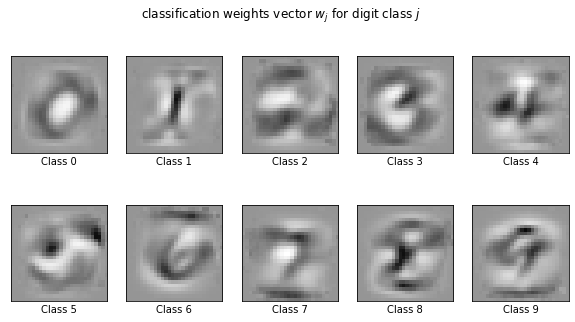

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot weights vs the pixel position
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l2_plot = plt.subplot(2, 5, i + 1)
    l2_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.Greys, vmin=-scale, vmax=scale)
    l2_plot.set_xticks(())
    l2_plot.set_yticks(())
    l2_plot.set_xlabel('Class %i' % i)
plt.suptitle('classification weights vector $w_j$ for digit class $j$')

plt.show()

### Exercises: ###  
- The snippet above invoked the "sag" solver which only deals with $L2$ regularization. Try another solver, e.g. 'liblinear', in scikit that supports $L1$ regularization. You can find more details on <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html"> http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html.</a>   

Below is code to run the SAGA solver with an L1 penalty. I initially tried liblinear but it ran very slow and SAGA is built to work better for large datasets. For the default $\lambda$ of $10^{-5}$, L2 and L1 work fairly similarly. They both have the same sparsity although L2 is slightly more accurate. I tried playing with $\lambda$ to see how that affected the results. As $\lambda$ increases, the L1 regularized coeficients become more and more sparse although interestingly even with 85% sparsity it still achieves over 80% accuracy. The images of these coefficients show that this sparse model is identifying features of individual strokes such as their curvature.

In [3]:
t0 = time.time()

lmbdas = np.logspace(-5,3,4)
sparsities = []
scores = []

for lmbda in lmbdas:
    # apply logistic regressor with 'saga' solver, C is the inverse regularization strength
    clf_saga = LogisticRegression(C=1/lmbda,
                                       multi_class='multinomial',
                                       penalty='l1', solver='saga', tol=0.1)
    # fit data
    clf_saga.fit(X_train, y_train)

    # percentage of nonzero weights
    sparsity = np.mean(clf_saga.coef_ == 0) * 100
    sparsities.append(sparsity)
    # compute accuracy
    score = clf_saga.score(X_test, y_test)
    scores.append(score)

    #display run time
    run_time = time.time() - t0
    print("lambda: {}".format(lmbda))
    print('Example run in %.3f s' % run_time)

    print("Sparsity with L1 penalty: %.2f%%" % sparsity)
    print("Test score with L1 penalty: %.4f" % score)

lambda: 1e-05
Example run in 26.736 s
Sparsity with L1 penalty: 9.06%
Test score with L1 penalty: 0.8908
lambda: 0.004641588833612777
Example run in 53.366 s
Sparsity with L1 penalty: 9.06%
Test score with L1 penalty: 0.8898
lambda: 2.154434690031882
Example run in 80.189 s
Sparsity with L1 penalty: 9.80%
Test score with L1 penalty: 0.8893
lambda: 1000.0
Example run in 109.749 s
Sparsity with L1 penalty: 83.74%
Test score with L1 penalty: 0.8447


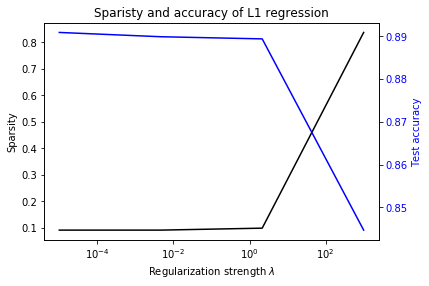

In [4]:
fig, ax1 = plt.subplots()
ax1.semilogx(lmbdas, np.asarray(sparsities)/100, "k")
ax1.set_xlabel("Regularization strength $\lambda$")
ax1.set_ylabel("Sparsity")

ax2 = ax1.twinx()
ax2.semilogx(lmbdas, scores, 'b')
ax2.set_ylabel("Test accuracy", color="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title("Sparisty and accuracy of L1 regression");

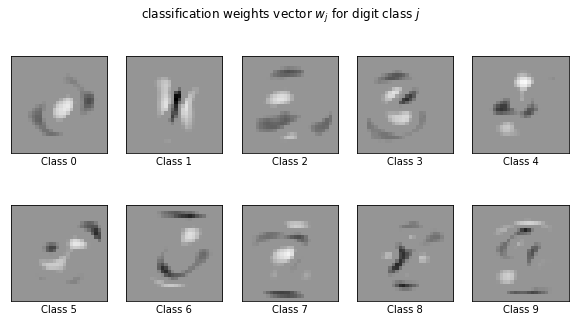

In [5]:
# plot weights vs the pixel position
coef = clf_saga.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.Greys, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('classification weights vector $w_j$ for digit class $j$')

plt.show()

- Visualize the misclassified samples. Analyze on how logistic regression performs on MNIST, and note this since we will study the MNIST problem later on using deep neural nets.

Below are images of misclassifieds digit from 0-9. Most of the digits that were misclassified seem to be written at an angle. This can potentially be solved through the use of convolutions which could be used to ignore the angle at which the digit is written. Another issue is when there are poorly defined features, such as loops that don't fully close or lines that don't extend fully.

Text(0.5, 0.98, 'Misclassified digits')

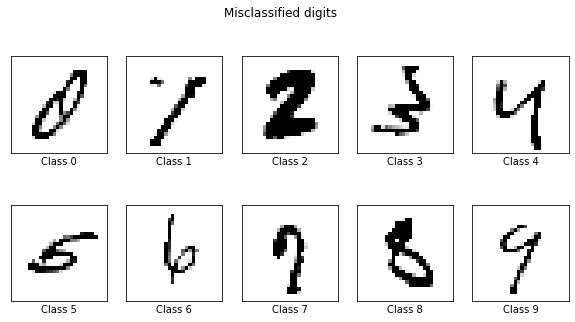

In [6]:
misclassified = np.where(y_test != clf.predict(X_test))
X_miss = X_test[misclassified]
y_miss = y_test[misclassified]

plt.figure(figsize=(10, 5))

for i in range(10):
    # Find first mismatch
    miss_1 = np.nonzero(y_miss==str(i))[0][0]
    
    miss_plot = plt.subplot(2, 5, i + 1)
    miss_plot.imshow(X_miss[miss_1].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.Greys, vmin=0, vmax=1)
    miss_plot.set_xticks(())
    miss_plot.set_yticks(())
    miss_plot.set_xlabel('Class %i' % i)

plt.suptitle('Misclassified digits')

- Try to vary the size of the training set and see how that affects the accuracy.

The code below subsamples the data down to $10^{-3}$ times the original size we were using. Both the training and test data sets were scaled the same (although there's definitely interesting effects that could happen if they were unequally scaled). We can see that in general sparsity goes down and test accuracy goes up as we increase the dataset size, although once we get to a large enough dataset the accuracy doesn't change much. The sparsity decreasing is possibly a bad sign, as it indicates that there are some small features that are only being picked up in large datasets. This could simply be spurious correlations that happen to be strong enough when we have a large enough training set to fit to.

In [7]:
t0 = time.time()

sizes = np.logspace(-3,0,7)
sparsities = []
scores = []

for size in sizes:
    # Redraw train and test sizes
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=int(train_size*size),test_size=int(test_size*size))

    # apply logistic regressor with 'sag' solver, C is the inverse regularization strength
    clf_size = LogisticRegression(C=1/lmbda,
                                       multi_class='multinomial',
                                       penalty='l2', solver='sag', tol=0.1)
    # fit data
    clf_size.fit(X_train, y_train)

    # percentage of nonzero weights
    sparsity = np.mean(clf_size.coef_ == 0) * 100
    sparsities.append(sparsity)
    # compute accuracy
    score = clf_size.score(X_test, y_test)
    scores.append(score)

    #display run time
    run_time = time.time() - t0
    print("size: {}".format(size))
    print('Example run in %.3f s' % run_time)

    print("Sparsity with L1 penalty: %.2f%%" % sparsity)
    print("Test score with L1 penalty: %.4f" % score)

size: 0.001
Example run in 0.053 s
Sparsity with L1 penalty: 40.69%
Test score with L1 penalty: 0.6000
size: 0.0031622776601683794
Example run in 0.095 s
Sparsity with L1 penalty: 31.76%
Test score with L1 penalty: 0.6774
size: 0.01
Example run in 0.178 s
Sparsity with L1 penalty: 25.51%
Test score with L1 penalty: 0.8800
size: 0.03162277660168379
Example run in 0.561 s
Sparsity with L1 penalty: 19.77%
Test score with L1 penalty: 0.8734
size: 0.1
Example run in 1.493 s
Sparsity with L1 penalty: 14.92%
Test score with L1 penalty: 0.9050
size: 0.31622776601683794
Example run in 4.832 s
Sparsity with L1 penalty: 12.12%
Test score with L1 penalty: 0.9099
size: 1.0
Example run in 15.162 s
Sparsity with L1 penalty: 9.31%
Test score with L1 penalty: 0.9201


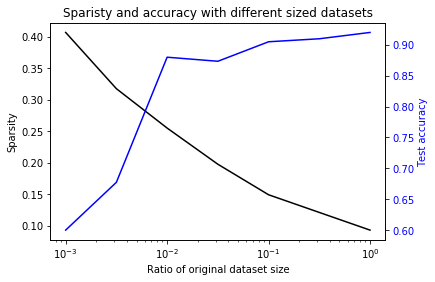

In [8]:
fig, ax1 = plt.subplots()
ax1.semilogx(sizes, np.asarray(sparsities)/100, "k")
ax1.set_xlabel("Ratio of original dataset size")
ax1.set_ylabel("Sparsity")

ax2 = ax1.twinx()
ax2.semilogx(sizes, scores, 'b')
ax2.set_ylabel("Test accuracy", color="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title("Sparisty and accuracy with different sized datasets");

- [Theory] In this notebook, we considered a $K=10$ multi-class logistic regression (MLR) also known as the SoftMax regression. Recall that the our model reads:
$$
p(y=i|\boldsymbol{x};W) = \frac{e^{\boldsymbol{w}_i^T \boldsymbol{x}}}{\sum_{j=0}^9 e^{\boldsymbol{w}_j^T \boldsymbol{x}}}
$$
Use this to construct the likelihood function $P(y|\boldsymbol{x})$.

Using the one-hot notation from the text, the likelihood function is:
$$\begin{equation}
P(y|x) = \prod_{i=1}^n \prod_{m=0}^{M-1} [P(y_{im}=1|x_i;w_m)]^{y_{im}}[1-P(y_{im}=1|x_i,w_m)]^{1-y_{im}}
\end{equation}$$

- [Theory] Now consider we're given a set of i.i.d. data $\mathcal{D}=\{(\boldsymbol{x}_1,y_1),\cdots, (\boldsymbol{x}_n,y_n)\}$. As we argued in the main text, the cross-entropy error used in logistic regression is motivated by maximizing the likelihood (or equivalently, minimizing the negative log-likelihood), find the corresponding error function $E(\boldsymbol{w}_0,\cdots,\boldsymbol{w}_9)$ in MLR using the hypothesis above. 

If we leave everything in this notation, the negative log likelihood $E$ is simply:
$$\begin{align}
E(w) = -\sum_{i=1}^n \sum_{m=0}^{M-1}&y_{im}\log[P(y_{im}=1|x_i;w_m)] \\
&+ (1-y_{im})\log[1-P(y_{im}=1|x_i,w_m)]
\end{align}$$
as all the multiplications simply become additions.

- [Theory] Using the error function derived above, calculate its gradient $\frac{\partial E}{\partial \boldsymbol{w}_k}$. Can you find an elegant way of writing the gradient?

As this equation is now additive, only the terms with $m=k$ contribute to the derivative so we have:
$$\begin{align}
\frac{\partial E}{\partial w_k} = -\sum_{i=1}^{n} &y_{ik}\frac{\partial}{\partial w_k}\log[P(y_{ik}=1|x_i;w_k)] \\
&+(1-y_{ik})\frac{\partial}{\partial w_k}\log[1-P(y_{ik}=1|x_i,w_k)]
\end{align}$$

As the derivative of the log of a partition function is the energy, we can write this as:
$$\begin{equation}
\frac{\partial E}{\partial w_k} = \sum_{i=1}^{n} y_{ik}E +(1-y_{ik})(1-E)
\end{equation}$$